# Random Forest Regression

## 1. Import Required Libraries

Import essential Python libraries for Random Forest implementation:
- **scikit-learn**: `RandomForestRegressor` for model building
- **pandas & numpy**: Data manipulation and numerical operations
- **matplotlib**: Visualization of results and model performance
- **sklearn.metrics**: Performance evaluation metrics (MSE, RMSE, MAE, R-Squared)
- **Optuna**: Bayesian Optimization for Hyperparameters

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import optuna
import warnings

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

## 2. Load and Prepare Dataset

Load the preprocessed training and test datasets from CSV files. These datasets have been prepared in the preprocessing stage and contain flight information with various features.

**Dataset Structure:**
- Training set: Used for model training and hyperparameter optimization
- Test set: Used for final model evaluation and performance assessment
- Target variable: `baseFare` (flight ticket price to predict)
- Features: Flight attributes such as departure/arrival times, airports, airlines, distance, etc.

In [2]:
train_data = pd.read_csv('data/train_data.csv')
test_data = pd.read_csv('data/test_data.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

print(train_data.info())

Training data shape: (125668, 50)
Test data shape: (31418, 50)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125668 entries, 0 to 125667
Data columns (total 50 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   elapsedDays                            125668 non-null  int64  
 1   isBasicEconomy                         125668 non-null  int64  
 2   seatsRemaining                         125668 non-null  int64  
 3   Booking Lead Time                      125668 non-null  int64  
 4   departureTime_sin                      125668 non-null  float64
 5   departureTime_cos                      125668 non-null  float64
 6   travelDuration_minutes                 125668 non-null  float64
 7   startingAirport_BOS                    125668 non-null  int64  
 8   startingAirport_CLT                    125668 non-null  int64  
 9   startingAirport_DEN                    125668 non-null  int64 

## 3. Feature Engineering and Data Preparation

Prepare features and target variables for Random Forest training. This step involves:

**Data Splitting:**
- Separate features (X) from target variable (y) for both training and test sets
- Target: `baseFare` - the flight ticket price we want to predict
- Features: All other columns containing flight information

In [3]:
target_column = 'baseFare'

y_train = train_data[target_column]
X_train = train_data.drop(columns=[target_column])

y_test = test_data[target_column]
X_test = test_data.drop(columns=[target_column])

## 4. Optuna Bayesian Optimization

Refine hyperparameters using Bayesian optimization. Optuna explores the space efficiently and can find better values between grid points.

Steps:
1. Define objective (5-fold CV, maximize negative MSE)
2. Create and run study (TPE + MedianPruner)
3. Train final RF using Optuna-best parameters

Objective: 5-fold CV maximizing negative MSE (i.e., better is closer to 0 from below)

In [4]:
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600, step=50),
        'max_depth': trial.suggest_int('max_depth', 8, 32, step=2),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 12, step=1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8, step=1),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    model = RandomForestRegressor(random_state=1, n_jobs=-1, **params)

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    return np.mean(scores)

Run study and report results:

In [5]:
study_rf = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=1),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=0,
        interval_steps=1
    ),
)

study_rf.optimize(rf_objective, n_trials=50, timeout=None, show_progress_bar=True)

best_neg_mse = study_rf.best_value
best_mse = -best_neg_mse
best_rmse = np.sqrt(best_mse)

print("Optuna Best Parameters:")
print(study_rf.best_params)
print(f"Best CV neg-MSE (maximize): {best_neg_mse:.6f}")
print(f"Best CV MSE: {best_mse:.6f}")
print(f"Best CV RMSE: {best_rmse:.6f}")
print(f"Number of trials: {len(study_rf.trials)}")
print(f"Pruned trials: {len([t for t in study_rf.trials if t.state == optuna.trial.TrialState.PRUNED])}")
print(f"Completed trials: {len([t for t in study_rf.trials if t.state == optuna.trial.TrialState.COMPLETE])}")

Best trial: 49. Best value: -0.0492759: 100%|██████████| 50/50 [53:46<00:00, 64.53s/it]

Optuna Best Parameters:
{'n_estimators': 450, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}
Best CV neg-MSE (maximize): -0.049276
Best CV MSE: 0.049276
Best CV RMSE: 0.221982
Number of trials: 50
Pruned trials: 0
Completed trials: 50


Train final model with Optuna-best params:

In [6]:
best_params_rf = study_rf.best_params
rf_regressor = RandomForestRegressor(random_state=1, n_jobs=-1, **best_params_rf)
rf_regressor.fit(X_train, y_train)

print("Final Optimized Model Configuration (Optuna)")
print(f"  n_estimators: {rf_regressor.n_estimators}")
print(f"  max_depth: {rf_regressor.max_depth}")
print(f"  min_samples_split: {rf_regressor.min_samples_split}")
print(f"  min_samples_leaf: {rf_regressor.min_samples_leaf}")
print(f"  max_features: {rf_regressor.max_features}")

Final Optimized Model Configuration (Optuna)
  n_estimators: 450
  max_depth: 32
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: None


## 5. Predictions with the Optimized Model

Generate predictions on the test dataset using the optimized Random Forest model obtained from Optuna.

In [7]:
y_pred_log = rf_regressor.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

print(f"Prediction range: ${y_pred.min():.2f} to ${y_pred.max():.2f}")
print(f"Mean prediction: ${y_pred.mean():.2f}")
print(f"Actual fare range: ${y_test_actual.min():.2f} to ${y_test_actual.max():.2f}")
    
results_df = pd.DataFrame({'Predicted_baseFare': y_pred})
results_df['Actual_baseFare'] = y_test_actual.values
results_df['Absolute_Error'] = np.abs(y_test_actual.values - y_pred)
results_df['Percentage_Error'] = (results_df['Absolute_Error'] / y_test_actual.values) * 100

Prediction range: $1.02 to $739.05
Mean prediction: $188.72
Actual fare range: $1.00 to $2976.74


## 6. Evaluating Model Performance

Comprehensive evaluation of the Random Forest model using multiple metrics to assess prediction quality.

In [8]:
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

r2_log = r2_score(y_test, y_pred_log)

mean_actual = y_test_actual.mean()
mean_predicted = y_pred.mean()

print(f"Performance metrics on the original scale)")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:.4f}")
print(f"R-squared Score (Original Scale): {r2:.4f}")
print(f"R-squared Score (Log Scale): {r2_log:.4f}")
print(f"Mean Actual Value: ${mean_actual:.2f}")
print(f"Mean Predicted Value: ${mean_predicted:.2f}")

Performance metrics on the original scale)
Mean Squared Error (MSE): 3271.0698
Root Mean Squared Error (RMSE): $57.1933
Mean Absolute Error (MAE): $25.5372
R-squared Score (Original Scale): 0.7617
R-squared Score (Log Scale): 0.8992
Mean Actual Value: $193.01
Mean Predicted Value: $188.72


## 7. Error Analysis

Detailed analysis of prediction errors to understand model strengths and weaknesses.

### Calculate Prediction Errors


Compute absolute and relative errors for detailed analysis.

In [9]:
y_test_actual_rf = np.expm1(y_test)
y_pred_actual_rf = y_pred

errors_rf = y_pred_actual_rf - y_test_actual_rf
abs_errors_rf = np.abs(errors_rf)
relative_errors_rf = (abs_errors_rf / y_test_actual_rf) * 100

error_df_rf = pd.DataFrame({
    'actual': y_test_actual_rf,
    'predicted': y_pred_actual_rf,
    'error': errors_rf,
    'abs_error': abs_errors_rf,
    'relative_error_pct': relative_errors_rf
})

### Prediction Range Check


First, verify that predictions and actuals are correctly transformed from log scale.

In [10]:
print(f"Actual fares ($):")
print(f"Min: {y_test_actual_rf.min():.2f} $")
print(f"Max: {y_test_actual_rf.max():.2f} $")
print(f"Mean: {y_test_actual_rf.mean():.2f} $")
print(f"Median: {y_test_actual_rf.median():.2f} $")

print(f"Predicted fares ($):")
print(f"Min: {y_pred_actual_rf.min():.2f} $")
print(f"Max: {y_pred_actual_rf.max():.2f} $")
print(f"Mean: {y_pred_actual_rf.mean():.2f} $")
print(f"Median: {np.median(y_pred_actual_rf):.2f} $")

print(f"Log-transformed predictions (before expm1):")
print(f"Min: {y_pred_log.min():.4f}")
print(f"Max: {y_pred_log.max():.4f}")
print(f"Mean: {y_pred_log.mean():.4f}")

Actual fares ($):
Min: 1.00 $
Max: 2976.74 $
Mean: 193.01 $
Median: 169.30 $
Predicted fares ($):
Min: 1.02 $
Max: 739.05 $
Mean: 188.72 $
Median: 170.30 $
Log-transformed predictions (before expm1):
Min: 0.7015
Max: 6.6067
Mean: 5.0871


### Comprehensive Visualization: Predictions and Residuals


Three-panel visualization showing actual vs predicted, residuals, and residual distribution.

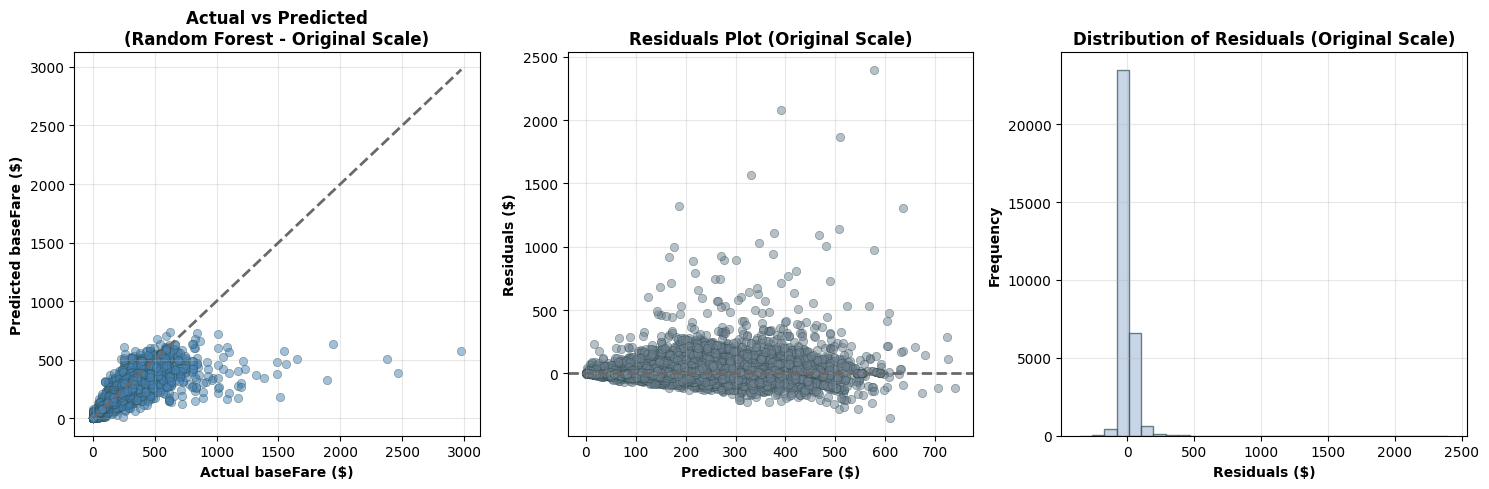

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test_actual_rf, y_pred_actual_rf, alpha=0.5, color='steelblue', edgecolors='darkslategray', linewidth=0.5)
plt.plot([y_test_actual_rf.min(), y_test_actual_rf.max()],
         [y_test_actual_rf.min(), y_test_actual_rf.max()], '--', color='dimgray', lw=2)
plt.xlabel('Actual baseFare ($)', fontweight='bold')
plt.ylabel('Predicted baseFare ($)', fontweight='bold')
plt.title('Actual vs Predicted\n(Random Forest - Original Scale)', fontweight='bold', fontsize=12)
plt.grid(True, alpha=0.3)

residuals_rf = y_test_actual_rf - y_pred_actual_rf
plt.subplot(1, 3, 2)
plt.scatter(y_pred_actual_rf, residuals_rf, alpha=0.5, color='slategray', edgecolors='darkslategray', linewidth=0.5)
plt.axhline(y=0, color='dimgray', linestyle='--', lw=2)
plt.xlabel('Predicted baseFare ($)', fontweight='bold')
plt.ylabel('Residuals ($)', fontweight='bold')
plt.title('Residuals Plot (Original Scale)', fontweight='bold', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(residuals_rf, bins=30, alpha=0.7, edgecolor='darkslategray', color='lightsteelblue')
plt.xlabel('Residuals ($)', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Distribution of Residuals (Original Scale)', fontweight='bold', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Analysis by Fare Range


Investigate how model performance varies across different price ranges.

Define fare ranges:

In [12]:
bins_rf = [0, 100, 200, 300, 500, 1000, 3000]
labels_rf = ['0-100 $', '100-200 $', '200-300 $', '300-500 $', '500-1000 $', '1000+ $']

error_df_rf['fare_range'] = pd.cut(error_df_rf['actual'], bins=bins_rf, labels=labels_rf)

Calculate metrics per range:

In [13]:
range_analysis_rf = error_df_rf.groupby('fare_range', observed=True).agg({
    'abs_error': ['mean', 'median', 'std'],
    'relative_error_pct': ['mean', 'median'],
    'actual': 'count'
}).round(2)

range_analysis_rf.columns = ['MAE', 'Median_AE', 'Std_AE', 'Mean_Rel_%', 'Median_Rel_%', 'Count']

Performance by Fare Range:

In [14]:
range_analysis_rf

,MAE,Median_AE,Std_AE,Mean_Rel_%,Median_Rel_%,Count
fare_range,,,,,,
0-100 $,12.07,6.41,15.22,21.45,10.65,5920
100-200 $,16.98,10.59,19.72,11.53,7.26,13162
200-300 $,27.33,18.63,28.94,11.29,7.65,7230
300-500 $,44.51,27.39,50.34,12.06,7.86,4642
500-1000 $,163.88,125.66,146.86,25.48,21.97,430
1000+ $,963.41,895.72,455.85,68.38,70.86,34


Visualization:

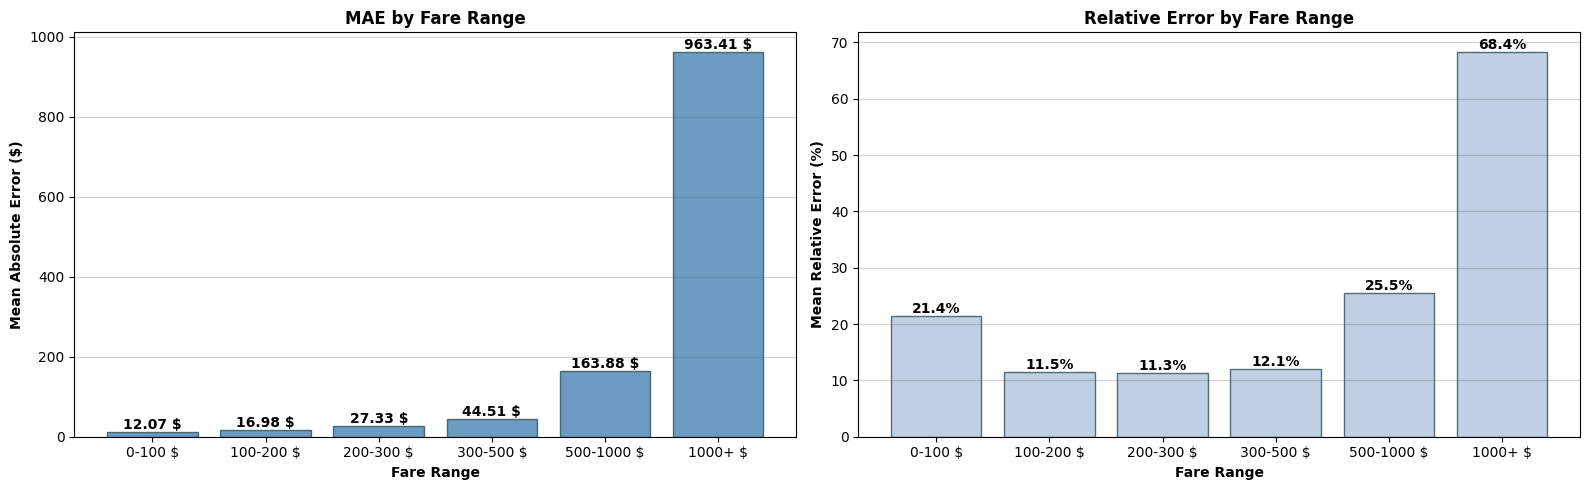

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].bar(range(len(range_analysis_rf)), range_analysis_rf['MAE'],
            color='steelblue', edgecolor='darkslategray', alpha=0.8)
axes[0].set_xticks(range(len(range_analysis_rf)))
axes[0].set_xticklabels(range_analysis_rf.index, rotation=0)
axes[0].set_ylabel('Mean Absolute Error ($)', fontweight='bold')
axes[0].set_xlabel('Fare Range', fontweight='bold')
axes[0].set_title('MAE by Fare Range', fontweight='bold', fontsize=12)
axes[0].grid(axis='y', alpha=0.3, color='dimgray')

for i, v in enumerate(range_analysis_rf['MAE']):
    axes[0].text(i, v, f'{v:.2f} $', ha='center', va='bottom', fontweight='bold')

axes[1].bar(range(len(range_analysis_rf)), range_analysis_rf['Mean_Rel_%'],
            color='lightsteelblue', edgecolor='darkslategray', alpha=0.8)
axes[1].set_xticks(range(len(range_analysis_rf)))
axes[1].set_xticklabels(range_analysis_rf.index, rotation=0)
axes[1].set_ylabel('Mean Relative Error (%)', fontweight='bold')
axes[1].set_xlabel('Fare Range', fontweight='bold')
axes[1].set_title('Relative Error by Fare Range', fontweight='bold', fontsize=12)
axes[1].grid(axis='y', alpha=0.3, color='dimgray')

for i, v in enumerate(range_analysis_rf['Mean_Rel_%']):
    axes[1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Worst Predictions Analysis


Identify and analyze the cases where the model performs worst. Top 10 worst results here.

In [16]:
worst_10_rf = error_df_rf.nlargest(10, 'abs_error')[['error', 'actual', 'predicted']]

worst_10_rf

,error,actual,predicted
26233,-2398.950318,2976.74,577.789682
774,-2076.334006,2467.91,391.575994
17750,-1868.199879,2377.67,509.470121
1689,-1562.917304,1893.02,330.102696
23645,-1324.040953,1510.70,186.659047
29395,-1302.750517,1938.60,635.849483
7432,-1140.198149,1646.51,506.311851
10957,-1111.532332,1488.37,376.837668
28578,-1095.319052,1561.86,466.540948
29753,-1033.585359,1380.47,346.884641


## 8. Feature Importance Analysis

Analyze which features contribute most to the Random Forest's prediction decisions. Feature importance scores indicate how much each feature reduces prediction error across all trees.

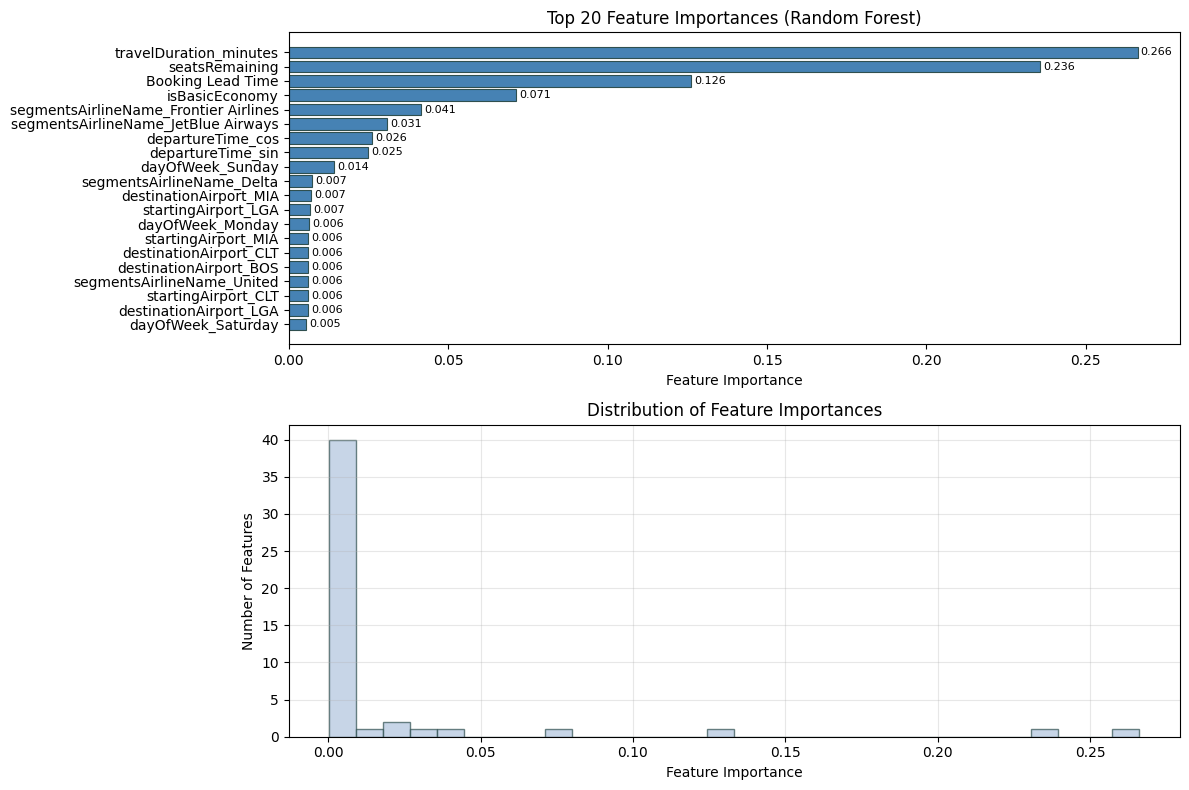

In [17]:
feature_importances = rf_regressor.feature_importances_
feature_names = rf_regressor.feature_names_in_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
top_features = importance_df.head(20)
bars = plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue', edgecolor='darkslategray', linewidth=0.8)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=8)

plt.subplot(2, 1, 2)
plt.hist(feature_importances, bins=30, alpha=0.7, color='lightsteelblue', edgecolor='darkslategray')
plt.xlabel('Feature Importance')
plt.ylabel('Number of Features')
plt.title('Distribution of Feature Importances')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Save Model

Persist the trained Random Forest model to disk for later use.

In [18]:
model_filename = 'models/random_forest_model.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(rf_regressor, file)

print(f"Model successfully saved to: {model_filename}")

Model successfully saved to: models/random_forest_model.pkl
